In [6]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import json
from IPython.display import display, HTML

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

# Columns: sample_size, distinct_values, variance, remainder_size, value, actual_count, filter_count

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

def select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size):
    return data[(data.value_count == value_count) &
                (data.distinct_values == distinct_values) &
                (data.data == data_distribution) & 
                (data.remainder_size == remainder_size) &
                (data.quotient_size == quotient_size)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * error
        
    return me

def misestimation_evaluation(quotient_size, remainder_size, data_distribution):
    value_count = 100000
    distinct_values = 3000

    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("cardinality_misestimation_" + data_distribution)
    selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    x_data = selection["over_estimation"]
    y_data = selection["occurrences"].apply(lambda x: x / sample_size)
    sample_size = selection["sample_size"].iloc[0]
    one_off_probability = y_data.iloc[1]
    correct_probability = y_data.iloc[0]
    mean_error = get_mean_error(x_data, y_data)
    mean_square_error = get_mean_squared_error(x_data, y_data)
    filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    filter_size_bytes = filter_size_bits / 8
    bits_per_value = filter_size_bits / value_count
    column_size = value_count * 2
    
    # Print some Information
    print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n'\
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(x_data[1:], y_data[1:].apply(lambda x: x * 100), color=hpi_red, label="filter counts")
    plt.ylabel('probability [%]')
    plt.xlabel('overcount')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_") \
                                        .replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    
    #Render
    plt.show()

def evaluate(quotient_size, remainder_size, data_distribution):
    value_count = 100000
    distinct_values = 3000
    variance = 500.0

    data = get_results("filter_cardinality_estimation_" + data_distribution)
    selection = select(data, value_count, distinct_values, variance, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    
    title = "Filter Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["filter_count"], color=hpi_red, label="filter counts")
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="actual counts")
    plt.legend(loc='upper left')
    plt.ylabel('value count')
    plt.xlabel('value')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_").replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()
    
def filter_comparison_table(quotient_sizes, remainder_sizes, data_distribution):
    value_count = 100000
    distinct_values = 3000
    
    data = get_results("cardinality_misestimation_" + data_distribution)
    filter_information = []
    
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
                selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
                if len(selection) == 0:
                    continue
                sample_size = selection["sample_size"].iloc[0]
                x_data = selection["over_estimation"]
                y_data = selection["occurrences"].apply(lambda x: x / sample_size)
                filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
                filter_size_bytes = filter_size_bits / 8
                bits_per_value = filter_size_bits / value_count
                mean_error = get_mean_error(x_data, y_data)
                mean_squared_error = get_mean_squared_error(x_data, y_data)
                correct_probability = y_data.iloc[0]
                filter_information.append((quotient_size, remainder_size, bits_per_value, mean_error, mean_squared_error))
    

    columns = ["Quotient Size", "Remainder Size", "Bits per Value", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(filter_information, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    

In [7]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "normal")

# Selection 0, 1, 2

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.376860,21.429247
1,14,8,1.63840,0.024536,1.393859
2,14,16,2.94912,0.000081,0.003621
3,15,2,1.31072,0.751799,42.925088
4,15,4,1.96608,0.187283,10.686966
5,15,8,3.27680,0.012598,0.720525
6,15,16,5.89824,0.000077,0.003431
7,16,2,2.62144,0.377405,21.457709
8,16,4,3.93216,0.094957,5.388018
9,16,8,6.55360,0.006256,0.353992


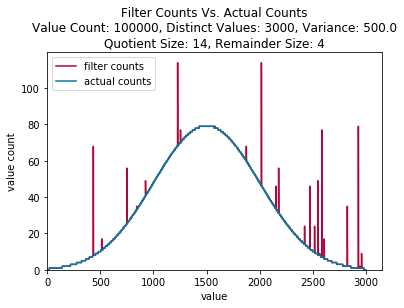

error 1 prob: 0.00090172
Mean Error: 0.376860133333
Mean Squared Error: 21.429247
Correct 98.879712% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


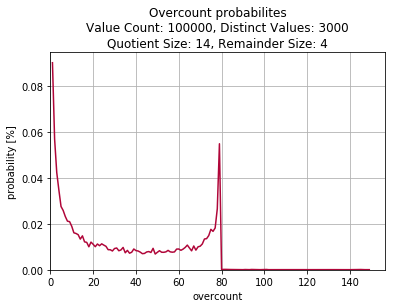

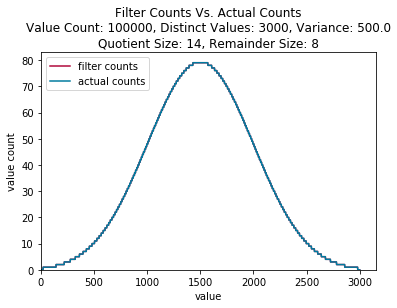

error 1 prob: 6.78033333333e-05
Mean Error: 0.0245355666667
Mean Squared Error: 1.39385936
Correct 99.9253096667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


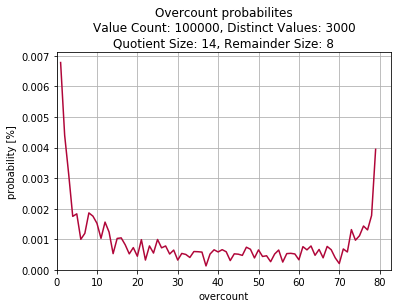

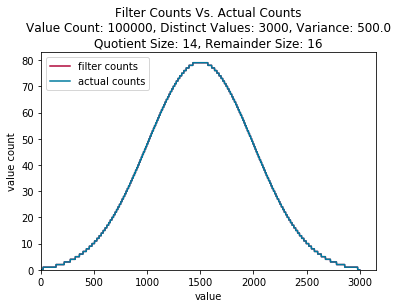

error 1 prob: 7.16666666667e-07
Mean Error: 8.116e-05
Mean Squared Error: 0.00362119333333
Correct 99.999728% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


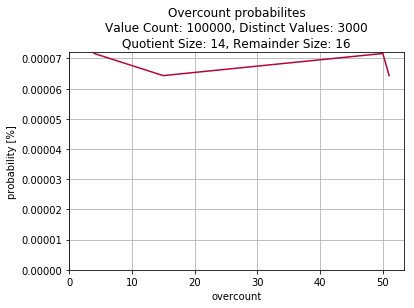

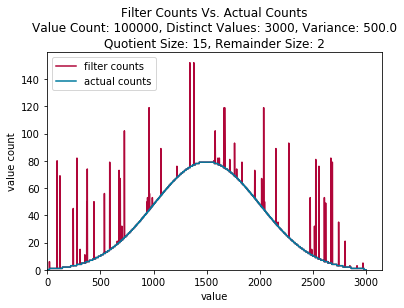

error 1 prob: 0.00175787333333
Mean Error: 0.751798523333
Mean Squared Error: 42.9250876633
Correct 97.76612% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


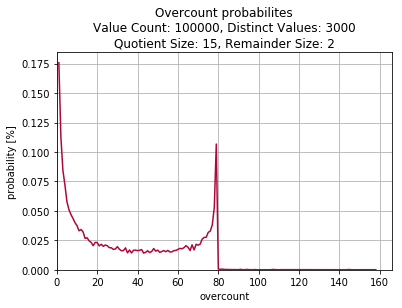

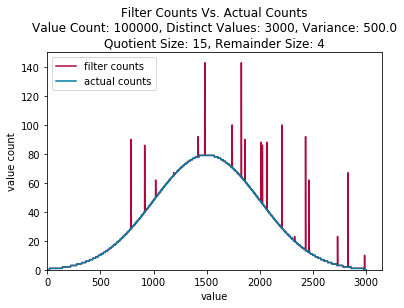

error 1 prob: 0.000451183333333
Mean Error: 0.18728317
Mean Squared Error: 10.6869656633
Correct 99.4414936667% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


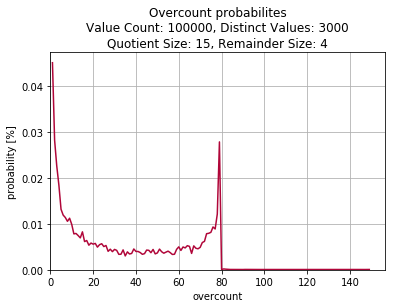

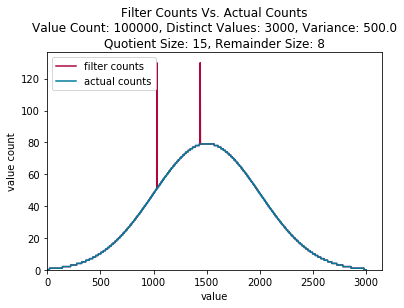

error 1 prob: 3.134e-05
Mean Error: 0.01259845
Mean Squared Error: 0.72052475
Correct 99.9632793333% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


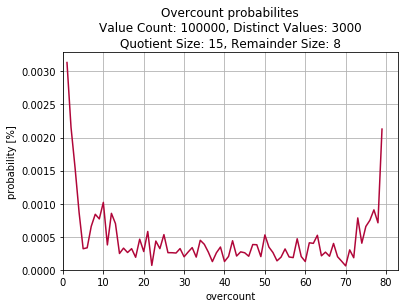

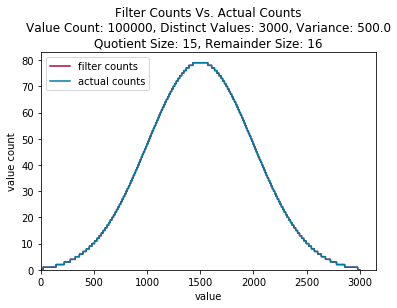

error 1 prob: 6.3e-07
Mean Error: 7.714e-05
Mean Squared Error: 0.0034314
Correct 99.9997433333% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


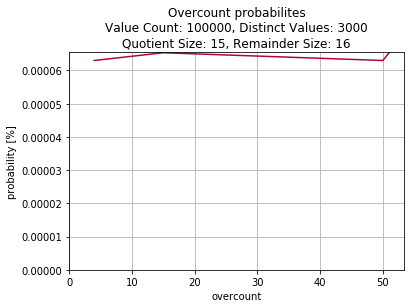

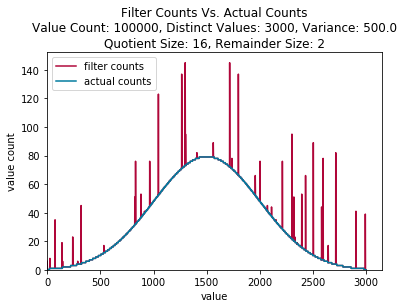

error 1 prob: 0.00090289
Mean Error: 0.377404623333
Mean Squared Error: 21.4577086433
Correct 98.877151% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


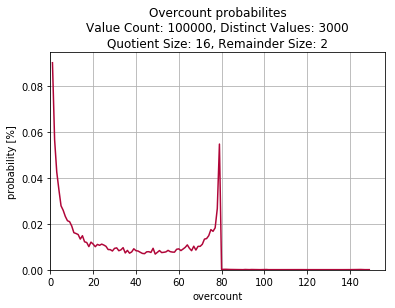

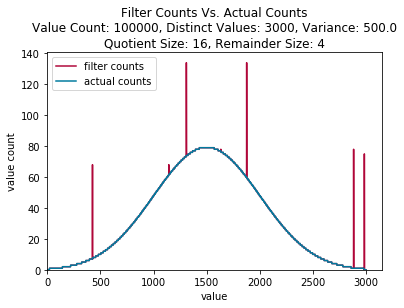

error 1 prob: 0.000228926666667
Mean Error: 0.09495717
Mean Squared Error: 5.38801820333
Correct 99.716009% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


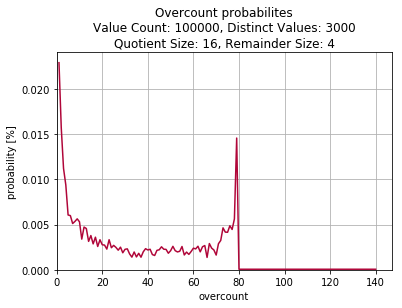

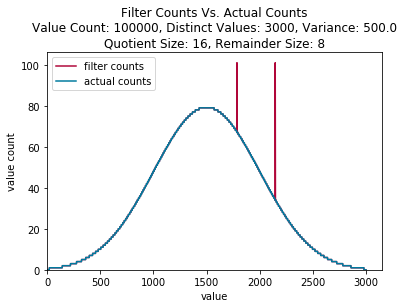

error 1 prob: 1.57733333333e-05
Mean Error: 0.00625627333333
Mean Squared Error: 0.3539915
Correct 99.9819246667% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


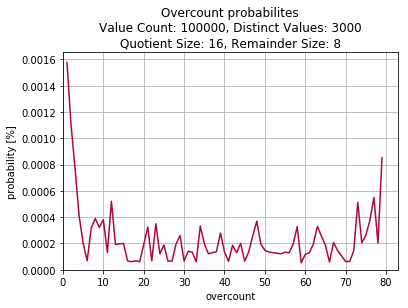

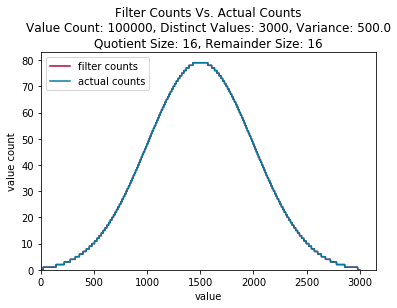

error 1 prob: 6.2e-07
Mean Error: 7.462e-05
Mean Squared Error: 0.00332146
Correct 99.9997513333% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


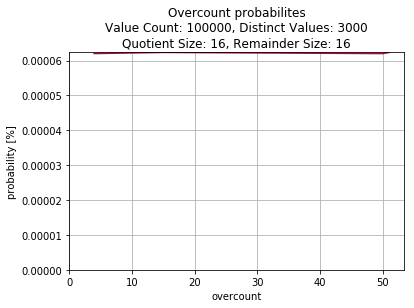

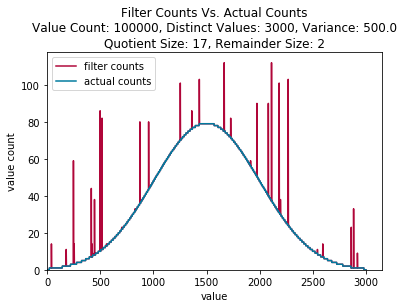

error 1 prob: 0.000450903333333
Mean Error: 0.18739289
Mean Squared Error: 10.6889220367
Correct 99.441298% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


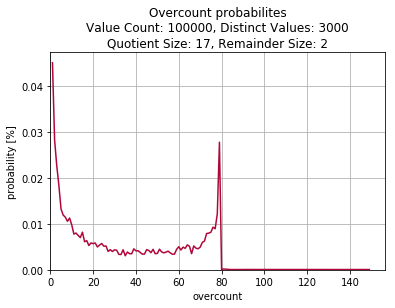

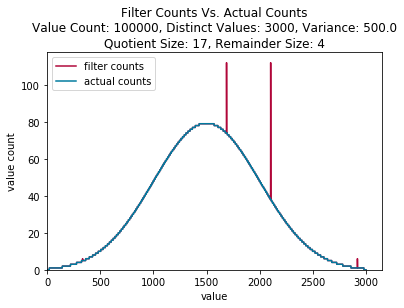

error 1 prob: 0.00012025
Mean Error: 0.05011846
Mean Squared Error: 2.86156761333
Correct 99.8522193333% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


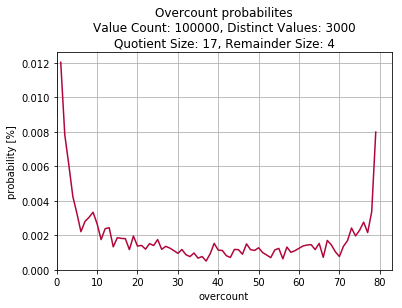

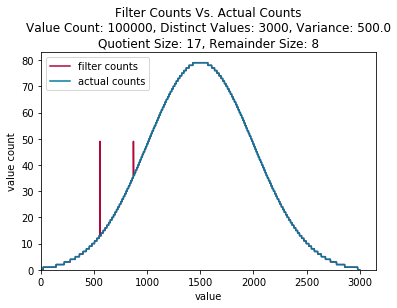

error 1 prob: 8.50333333333e-06
Mean Error: 0.00260039333333
Mean Squared Error: 0.138565653333
Correct 99.9917123333% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


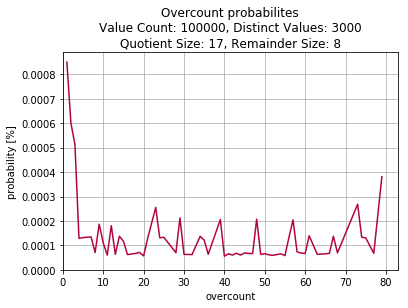

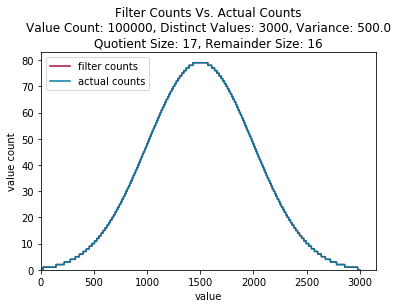

error 1 prob: 6.16666666667e-07
Mean Error: 7.642e-05
Mean Squared Error: 0.00339785333333
Correct 99.999746% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


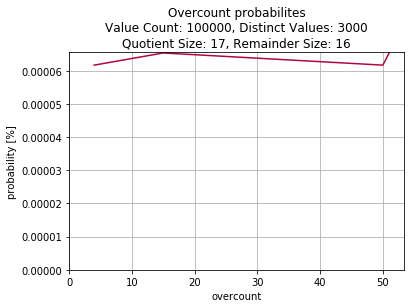

In [9]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "normal")
        misestimation_evaluation(quotient_size, remainder_size, "normal")

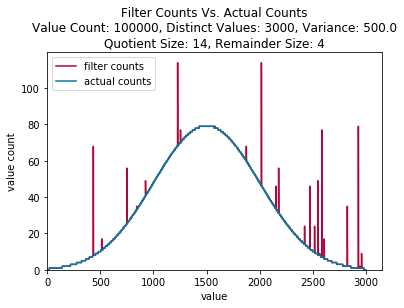

error 1 prob: 0.00090172
Mean Error: 0.376860133333
Mean Squared Error: 21.429247
Correct 98.879712% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


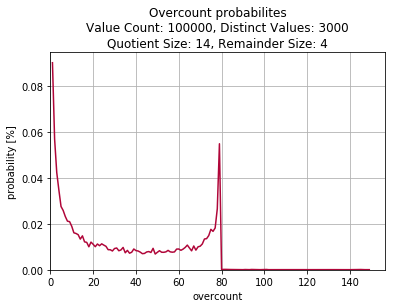

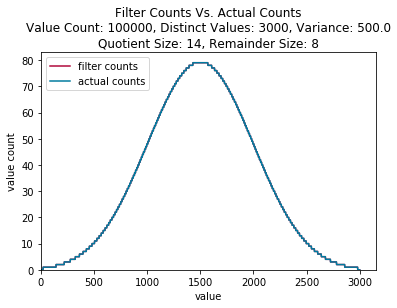

error 1 prob: 6.78033333333e-05
Mean Error: 0.0245355666667
Mean Squared Error: 1.39385936
Correct 99.9253096667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


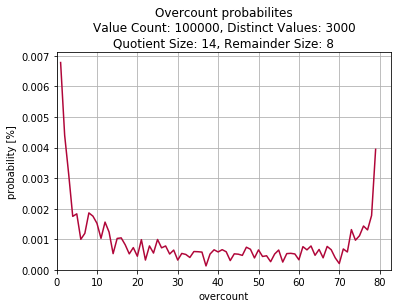

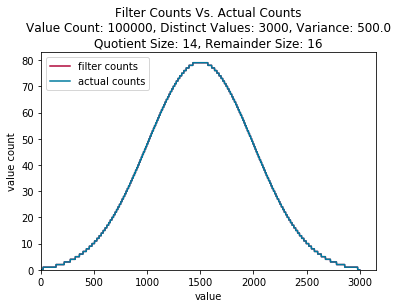

error 1 prob: 7.16666666667e-07
Mean Error: 8.116e-05
Mean Squared Error: 0.00362119333333
Correct 99.999728% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


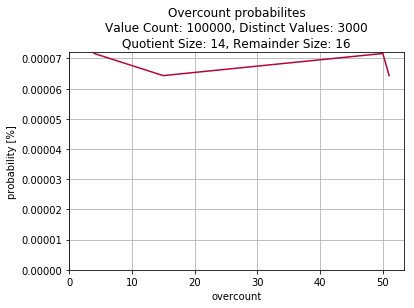

In [10]:
evaluate(quotient_size=14, remainder_size=4, "normal")
misestimation_evaluation(quotient_size=14, remainder_size=4, "normal")
evaluate(quotient_size=14, remainder_size=8, "normal")
misestimation_evaluation(quotient_size=14, remainder_size=8, "normal")
evaluate(quotient_size=14, remainder_size=16, "normal")
misestimation_evaluation(quotient_size=14, remainder_size=16, "normal")